# Misinformation Game Logo

This notebook contains code to generate the Misinformation Game's logo.

In [1]:
# The width and height of the generated logo-full.png
width = 1024

# A multiplier for the size of the image to help with anti-aliasing.
superSampling = 8

In [2]:
import pathlib
import math
import numpy as np
from PIL import Image, ImageDraw


# The width of the image with super-sampling.
ssWidth = width * superSampling


# The number of points around the circle.
pointCount = 8


# Generate the outer circle of the logo.
logo = Image.new("RGBA", (ssWidth, ssWidth))
logoDraw = ImageDraw.Draw(logo)
outerWidth = int(0.025 * ssWidth)
offset = outerWidth
circleBounds = [(offset, offset), (ssWidth - 1 - offset, ssWidth - 1 - offset)]
logoDraw.ellipse(circleBounds, fill="#FFFFFF")


# Generate the mask representing the circle of the logo.
# This is used to remove the ends of lines that extend over the circle.
mask = Image.new("L", (ssWidth, ssWidth), color=0)
maskDraw = ImageDraw.Draw(mask)
maskDraw.ellipse(circleBounds, fill=255)


# Generate the points around the circle to connect.
radius = (ssWidth - 2 * outerWidth) / 2
centreX, centreY = ssWidth // 2, ssWidth // 2
d2r = 2.0 * math.pi / 360.0
points = [(
    centreX + radius * math.cos(a * d2r),
    centreY + radius * math.sin(a * d2r)
) for a in range(0, 360, 360 // pointCount)]


# Generate the lines between points on the circle.
lineWidth = int(0.025 * ssWidth)
for i1, p1 in enumerate(points):
    for i2, p2 in enumerate(points):
        # Avoid redundant drawing.
        if i2 <= i1:
            continue

        # Longer lines are made thicker.
        dist = math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
        thisLineWidth = lineWidth + int(0.05 * max(0, dist - 1.5 * radius))
        logoDraw.line([p1, p2], fill="#000000", width=thisLineWidth)


# Remove white on the outsides of the logo.
pixels = np.array(logo)
maskPixels = np.array(mask)
for row in range(ssWidth):
    rowPixels = pixels[row]
    rowMaskPixels = maskPixels[row]
    blackPixels = ((rowPixels[:, 0] == 0) &
                   (rowPixels[:, 1] == 0) &
                   (rowPixels[:, 2] == 0) &
                   (rowPixels[:, 3] > 0))

    start = np.argmax(blackPixels)
    end = len(blackPixels) - 1 - np.argmax(blackPixels[::-1])
    if start < end:
        rowMaskPixels[:start] = 0
        rowMaskPixels[end:] = 0

mask = Image.fromarray(maskPixels, "L")
maskDraw = ImageDraw.Draw(mask)


# Smooth out the corners of the logo.
for index, point in enumerate(points):
    x, y = point

    # Calculate the direction towards the centre of the logo.
    dx, dy = centreX - x, centreY - y
    dl = math.sqrt(dx**2 + dy**2)
    ux, uy = dx / dl, dy / dl

    # Calculate the angle to the points that are to the left and right of this point.
    leftX, leftY = points[(index - 1) % len(points)]
    rightX, rightY = points[(index + 1) % len(points)]
    leftAngle = math.atan2(leftY - y, leftX - x)
    rightAngle = math.atan2(rightY - y, rightX - x)

    # Calculate the points that we want to draw an arc between.
    radius = 0.1 * ssWidth
    leftFromX, leftFromY = (
        x + radius * math.cos(leftAngle),
        y + radius * math.sin(leftAngle)
    )
    rightFromX, rightFromY = (
        x + radius * math.cos(rightAngle),
        y + radius * math.sin(rightAngle)
    )

    # Calculate the centre of the circle to draw the arc.
    leftAngle -= math.pi / 2
    rightAngle += math.pi / 2

    dSin = math.sin(rightAngle) - math.sin(leftAngle)
    dCos = math.cos(rightAngle) - math.cos(leftAngle)
    if abs(dSin) > abs(dCos):
        t = (leftFromY - rightFromY) / dSin
    else:
        t = (leftFromX - rightFromX) / dCos

    circleCentreX = leftFromX + math.cos(leftAngle) * t
    circleCentreY = leftFromY + math.sin(leftAngle) * t
    circleRadius = abs(t)

    # Draw the arc, offset so that it lines up with the lines between the points.
    lineWidth = int(0.02 * ssWidth)
    dx, dy = -1.75 * ux * lineWidth, -1.75 * uy * lineWidth
    maskDraw.arc(
        [
            (int(circleCentreX - circleRadius + dx), int(circleCentreY - circleRadius + dy)),
            (int(circleCentreX + circleRadius + dx), int(circleCentreY + circleRadius + dy))
        ],
        (leftAngle / d2r + 540) % 360,
        (rightAngle / d2r + 540) % 360,
        fill=0,
        width=lineWidth
    )


# Apply the mask.
logo.putalpha(mask)


# Resize the super-sampled logo back to the target width.
logoFull = logo.resize((width, width), resample=Image.Resampling.LANCZOS)


# Save the image!
pathlib.Path("out").mkdir(exist_ok=True)
logoFull.save("out/logo-full.png")

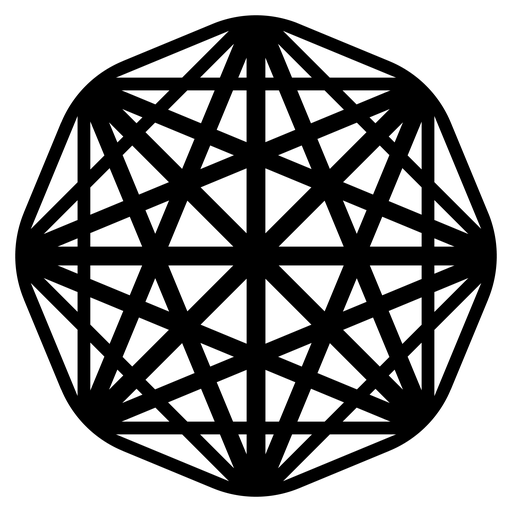

In [3]:
logoLarge = logo.resize((512, 512), resample=Image.Resampling.LANCZOS)
logoLarge.save("out/logo-large.png")
logoLarge

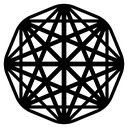

In [4]:
logoMedium = logo.resize((128, 128), resample=Image.Resampling.LANCZOS)
logoMedium.save("out/logo-medium.png")
logoMedium

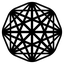

In [5]:
logoSmall = logo.resize((64, 64), resample=Image.Resampling.LANCZOS)
logoSmall.save("out/logo-small.png")
logoSmall

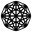

In [6]:
logoTiny = logo.resize((32, 32), resample=Image.Resampling.LANCZOS)
logoTiny.save("out/logo-tiny.png")
logoTiny